In [28]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # to read records completely
import pickle
import numpy as np
import itertools
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


## Data Prep

In [2]:
# Importing the data scraped and pre-processed in part A
df = pd.read_pickle('data_clean.pkl')

In [3]:
models = pd.read_csv('models.csv', header=None, names = ['brand', 'model'])
models['brand'] = models['brand'].str.replace(r'[^\w\s]+', '', regex=True) # clean some punctuation errors (nissan.)
models = models[~models.brand.isin(['car', 'sedan', 'problem'])] # remove rows that are not brands

In [4]:
df.Message.str.contains('said').sum()

370

In [5]:
#.lower() on all words
df.Message_words = df.Message_words.apply(lambda x: [i.lower() for i in x])

## Replace models with brands

In [6]:
messages = df.Message_words.to_list()

In [7]:
# numpy.where to do the replacement. Replaces only first appearance of brand.
# ~ 5-10 minutes of execute
messages2 = []
t = 0
for m in messages:
    for i,row in models.iterrows():
        m = np.where(m == row['model'], row['brand'], m)
        
    t+=1
    
    #print(t)
        
    messages2.append(m)
        
df['Message_words_v2'] = messages2

In [8]:
# let's find the occurences of changes
m1 = df.Message_words.to_list()
m2 = df.Message_words_v2.to_list()

c = 0
W = 0
for i in range(len(m2)):
    for j in range(len(m2[i])):
        if m1[i][j] != m2[i][j]: #word by word comparison
            c +=1
        W += 1 # if we want to count all words

In [9]:
print(f'{c} changes of models')

6368 changes of models


In [10]:
df[['Message_words', 'Message_words_v2']].head(10)

,Message_words,Message_words_v2
0,"[need, help, choosing, next, vehicle, tell, us, price, range, thinking, new, used, buying, leasing, features, musthaves, thoughts, mind, let, us, give, hand, tell, us, criteria, specifically, canyoull, find, lots, helpful, folks, give, useful, suggestions]","[need, help, choosing, next, vehicle, tell, us, price, range, thinking, new, used, buying, leasing, features, musthaves, thoughts, mind, let, us, give, hand, tell, us, criteria, specifically, canyoull, find, lots, helpful, folks, give, useful, suggestions]"
1,"[im, buying, new, car, end, year, first, choice, nissan, maxima, ive, read, reliable, hold, value, well, budget, probably, going, allow, 9899, wondering, worth, buying, car, thats, almost, 34, years, old, suggestions, comments, would, help, lotwillow25]","[im, buying, new, car, end, year, first, choice, nissan, nissan, ive, read, reliable, hold, value, well, budget, probably, going, allow, 9899, wondering, worth, buying, car, thats, almost, 34, years, old, suggestions, comments, would, help, lotwillow25]"
2,"[buy, 2001, 2002, oldsmobile, intrigue, one, best, sedans, market, great, handling, one, best, v6, engines, around, 35l, dohc, producing, 215hp, deals, great, year, last, intrigue, warrany, extended, 5, years, car, recommended, magazines, including, consumer, reports, unfortunately, looked, consumers, sleeper, sleepers, market, opinion]","[buy, 2001, 2002, oldsmobile, intrigue, one, best, sedans, market, great, handling, one, best, v6, engines, around, 35l, dohc, producing, 215hp, deals, great, year, last, intrigue, warrany, extended, 5, years, car, recommended, magazines, including, consumer, reports, unfortunately, looked, consumers, sleeper, sleepers, market, opinion]"
3,"[looking, 1, 4, choices, replace, 99gs400, ive, read, everything, forums, seen, much, conflicting, info4, optionslexus, ls430, customluxury, packageinfiniti, q45, premium, pckgaudi, a6, 42, loaded, audi, a8, stripped, loadedchicago, wintershad, blizzaks, gsworked, fine, 95q, pig, snow, im, sure, 2002q, world, away, ive, heard, audi, qc, problems, like, maintenance, included, im, happy, lexus, driver, q, appears, offer, lease, economy, would, think, could, command, attractive, package, go, wrong, 4, missing, something]","[looking, 1, 4, choices, replace, 99gs400, ive, read, everything, forums, seen, much, conflicting, info4, optionslexus, ls430, customluxury, packageinfiniti, q45, premium, pckgaudi, audi, 42, loaded, audi, audi, stripped, loadedchicago, wintershad, blizzaks, gsworked, fine, 95q, pig, snow, im, sure, 2002q, world, away, ive, heard, audi, qc, problems, like, maintenance, included, im, happy, lexus, driver, q, appears, offer, lease, economy, would, think, could, command, attractive, package, go, wrong, 4, missing, something]"
4,"[generally, 34, year, old, car, range, good, one, basically, sound, possible, get, one, still, warrenty, make, sure, trusted, maxima, mechanic, goes, thoroughly, v6, one, best, rated, 10, years, personally, amazed, great, strides, american, quality, recently, olds, may, bad, idea]","[generally, 34, year, old, car, range, good, one, basically, sound, possible, get, one, still, warrenty, make, sure, trusted, nissan, mechanic, goes, thoroughly, v6, one, best, rated, 10, years, personally, amazed, great, strides, american, quality, recently, olds, may, bad, idea]"
5,"[maxima, intrigue, excellent, choices, midsize, sedans]","[nissan, intrigue, excellent, choices, midsize, sedans]"
6,"[kind, budget, would, go, a6, 42, best, combination, sport, luxury, amongst, 4, choices]","[kind, budget, would, go, audi, 42, best, combination, sport, luxury, amongst, 4, choices]"
7,"[actually, agree, a6, looked, specs, edmunds, a6, a8, 4000, lbs, considering, a8, gets, bump, hp, a6, dont, think, performance, difference, issue, considering, fact, a6, would, possibly, small, based, rest, list, say, go, a8, think, youll, find, awd, best, addition, car, could, ever, hoped]","[actually, agree, aud

In [11]:
#Now we have cases where the text says "nissan", "nissan" because we replaced the model. Let's clean that
#Removing duplicates in lists while keeping order
def remove_consecutive_duplicate (text): #removes consecutive duplicates
    return np.array([i for i, j in itertools.groupby(text)])

df["Message_words_v3"] = df["Message_words_v2"].apply(remove_consecutive_duplicate)

## Link attributes to models

In [12]:
# first lets count brand mentions in each record
#Get a unique list of brands
brands_list = models.brand.drop_duplicates().to_list()

brands_list.extend(['lexus', 'ferrari', 'merzedesbenz', 'tesla','gm', 'peugeot', 'jeep', 'bentley', 'fiat'])

In [13]:
messages = df.Message_words_v3.to_list()

#Get a nested list of brands mentioned in reviews
brands_in_message = []
for m in messages:
    
    brands_mentioned = []
    for brand in brands_list:
        if len(np.where(m == brand)[0]) >0:
            brands_mentioned.append(brand)
            
    brands_in_message.append(brands_mentioned)
        
    

C:\Users\louis\AppData\Local\Temp/ipykernel_9684/1349755546.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if len(np.where(m == brand)[0]) >0:


In [14]:
df['Brands_in_message'] = brands_in_message
df['Qty_brands'] = df.Brands_in_message.apply(lambda x: len(x))
df['Qty_brands'].value_counts()

# 1291 messages don't mention any brand (remove them from analysis?)
# Most messages discuss a single brand
# Also common to compare 2 brands

0     1244
1     1175
2      774
3      464
4      235
5      120
6       74
7       31
8       17
10       7
11       3
12       3
9        2
16       1
13       1
Name: Qty_brands, dtype: int64

In [15]:
df.loc[df.Qty_brands == 0, 'Message_words_v3'].head(10) # to review records with no brand mentions
# most of them are for seeking advice

0                                                                                       [need, help, choosing, next, vehicle, tell, us, price, range, thinking, new, used, buying, leasing, features, musthaves, thoughts, mind, let, us, give, hand, tell, us, criteria, specifically, canyoull, find, lots, helpful, folks, give, useful, suggestions]
2     [buy, 2001, 2002, oldsmobile, intrigue, one, best, sedans, market, great, handling, one, best, v6, engines, around, 35l, dohc, producing, 215hp, deals, great, year, last, intrigue, warrany, extended, 5, years, car, recommended, magazines, including, consumer, reports, unfortunately, looked, consumers, sleeper, sleepers, market, opinion]
8                                                                                                                                                                                                                                                                                      [id, pass, intrigue, one, reaso

We can assign attributes mentioned in the reviews, like the power of a car, to a specific brand. For example, in the sentence "I like the BMW for its power. On the other hand, the Honda is reliable" we would want to assign the the attribute "power" to "BMW" and "reliable" to "Honda". We have created functions for two different approaches:
1) assign all words found between 1st brand mention and next brand mention to 1st brand

2) assign n words to each side of the brand mention to the brand. We found n = 4 to work best. 

In [16]:
# First approach: link all words found between brand mention and next brand mention.
# Except for first brand which also receives words since beginning of message

m = df.Message_words_v3[9] #record 9 is a good exaple

def get_attr_in_the_right(m, brand_list):

    brand_dic = {}
    for brand in brands_list:
        ix = np.where(m == brand)[0]
        if len(ix) > 0:
            brand_dic[brand] = ix[0]


    brand_dic = dict(sorted(brand_dic.items(), key=lambda x:x[1]))

    brand_list = list(brand_dic.values()) + [len(m)]

    review={}
    for i, tup in enumerate(brand_dic):
#         print(brand_dic[tup])
#         print(tup)
        
        if i == 0:
            
            review[tup] = m[0:brand_list[1]]
        else:
            review[tup] = m[brand_list[i]:brand_list[i+1]]
            
    return review



get_attr_in_the_right(m, brands_list) #was brand_list, ASK CARLOS    

{'honda': array(['would', 'recommend', 'honda'], dtype='<U12'),
 'toyota': array(['toyota', 'choices', 'sedan', 'new'], dtype='<U12'),
 'nissan': array(['nissan', 'looks', 'impressive', 'would', 'wait', 'reliability',
        '2002', 'proventhe', 'new'], dtype='<U12'),
 'bmw': array(['bmw', '525', 'another', 'nice', 'car', 'rated', 'highly', 'many',
        'auto', 'publications'], dtype='<U12')}

In [17]:
# now we run it for all records

brand_reviews_1st_approach = []

for m in df.Message_words_v3:

    brand_reviews_1st_approach.append(get_attr_in_the_right(m, brands_list))

# generates a list (1 entry per row) of dictionaries {brand_1: part of text corresponding, 
# brand_2: part of text corresponding,}

C:\Users\louis\AppData\Local\Temp/ipykernel_9684/2213854526.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  ix = np.where(m == brand)[0]


In [18]:


review_accum_1st = {i:[] for i in brands_list} #deprecated dictionary but still interesting

for brand in brands_list:
    for review in brand_reviews_1st_approach:
        for single_review in review:
            #print(review[single_review])
            if single_review==brand:
                review_accum_1st[brand].extend(review[single_review])

## Task E: Finding Aspirational Brands
Approach: Measure "ASPIRATION" as a distance between **their market share rank** and their **positive-comments share rank**

Step 1: Get a list of positive-sentiment words and count appearances for each brand

In [19]:
#import positive attributes
pos_df = pd.read_csv('positive_indicator.csv') # words manually tagged as positive

pos_attributes = list(pos_df[pos_df.positive_indicator == 1].word)
brands = list(review_accum_1st.keys())

pos_attribute_count = []

for brand in brands: 
    count = 0
    for i in pos_attributes: 
        for j in review_accum_1st[brand]: 
            if j == i:
                count += 1
    
    pos_attribute_count.append(count)


results_df = pd.DataFrame({'brand': brands, 'count': pos_attribute_count})
results_df['rel_freq'] = results_df['count']*100/results_df['count'].sum()
results_df.sort_values('count', ascending= False).reset_index(drop=True)


# we remove brands with count = 0 and add a rank columns
results_df = results_df[results_df['count'] > 0 ]

results_df['pos_comment_rank'] = results_df['rel_freq'].rank(ascending=False)

Step 2: Get brand share info from an external datasource and rank the brands according to their market share

 - Source: GoodCarBadCar, 2019:  https://www.goodcarbadcar.net/2019-u-s-auto-sales-figures-by-brand/

In [20]:
df_share = pd.read_excel('brand_share.xlsx')
df_share.Brand = df_share.Brand.str.lower()
df_share['rel_share'] = df_share.YTD*100/df_share.YTD.sum()
df_share['share_rank'] = df_share.rel_share.rank(ascending = False)

Step 3: Merge both data sources and look for largest distances (deltas)

In [21]:
df_share = df_share.merge(results_df, left_on = 'Brand', right_on = 'brand')

In [22]:
df_share['dif_in_rank'] = df_share.share_rank - df_share.pos_comment_rank

In [23]:
df_share['dif_in_rank']

0      9.0
1      9.0
2      7.0
3      2.5
4     -1.5
5     -1.0
6     12.0
7     -9.0
8     -9.0
9      2.0
10    -6.0
11     5.5
12   -19.5
13   -12.0
14    -0.5
15    -2.5
16    10.0
17    -4.5
18     2.0
19   -10.0
20     1.0
21     8.0
22    13.0
Name: dif_in_rank, dtype: float64

In [81]:
df_bubbleplot = df_share.sort_values('dif_in_rank', ascending=False)[[
    'Brand','share_rank', 'pos_comment_rank','dif_in_rank']].reset_index(drop=True)

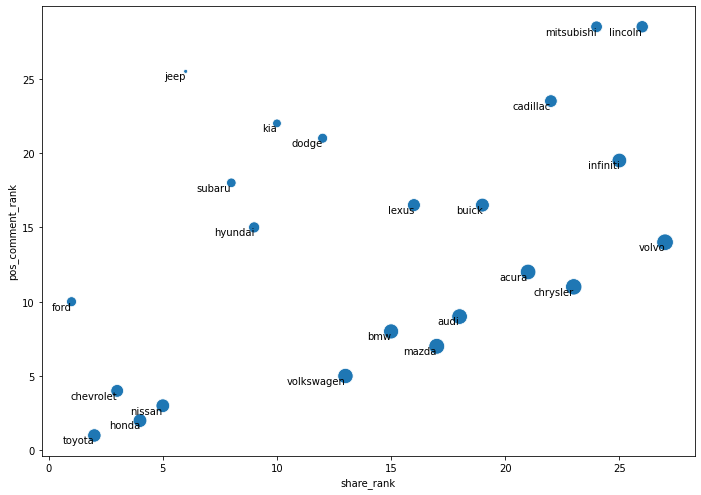

In [110]:
df_bubbleplot['dif_in_rank_scaled'] = df_bubbleplot['dif_in_rank'] + abs(min(df_bubbleplot['dif_in_rank'])) + 2
minsize = min(df_bubbleplot['dif_in_rank_scaled'])*8
maxsize = max(df_bubbleplot['dif_in_rank_scaled'])*8

fig, ax = plt.subplots(figsize = (11.7, 8.27))

ax = sns.scatterplot(data=df_bubbleplot, x="share_rank", y="pos_comment_rank", size = "dif_in_rank", 
                     legend=False, sizes=(minsize,maxsize))

for line in range(0,df_bubbleplot.shape[0]):
     ax.text(df_bubbleplot.share_rank[line], df_bubbleplot.pos_comment_rank[line], 
     df_bubbleplot.Brand[line], horizontalalignment='right', verticalalignment='top',
     size='medium', color='black')

plt.show()


In [89]:
df_bubbleplot

,Brand,share_rank,pos_comment_rank,dif_in_rank,dif_in_rank_scaled
0,volvo,27.0,14.0,13.0,32.5
1,chrysler,23.0,11.0,12.0,31.5
2,mazda,17.0,7.0,10.0,29.5
3,audi,18.0,9.0,9.0,28.5
4,acura,21.0,12.0,9.0,28.5
5,volkswagen,13.0,5.0,8.0,27.5
6,bmw,15.0,8.0,7.0,26.5
7,infiniti,25.0,19.5,5.5,25.0
8,buick,19.0,16.5,2.5,22.0
9,honda,4.0,2.0,2.0,21.5
